# Carga Dataset

In [6]:
#Sube un archivo de Kaggle a la Máquina Virtual de Colab en un .zip
#Requiere tener el archivo 'kaggle.json' en Drive
#Requiere aceptar las reglas de la competencia en Kaggle

import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/kaggle.json", 'r') as f:
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c tp2-predictivo-2023q2

Mounted at /content/drive
 90% 36.0M/40.2M [00:00<00:00, 45.4MB/s]
100% 40.2M/40.2M [00:00<00:00, 45.8MB/s]


In [7]:
#Extraigo todos los archivos que están en el .zip que acabamos de "bajar".
import zipfile
import os

os.listdir()

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

In [5]:
_=!pip install feature_engine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#exportar pipes
import pickle
import joblib

#crear directorio caché
from tempfile import mkdtemp
from shutil import rmtree

# from tqdm import tqdm
# from sklearn import set_config
# from sklearn.base import clone

#pipeline y search
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid, train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectPercentile, chi2

#modelos
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

#transformaciones
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder, OneHotEncoder, CountFrequencyEncoder
from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer, EndTailImputer, RandomSampleImputer
from feature_engine.transformation import PowerTransformer
from feature_engine.creation import RelativeFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

#distribuciones
import scipy as sp
from scipy.stats import randint, uniform

# from sklearn.compose import ColumnTransformer, make_column_transformer
# from sklearn.impute import KNNImputer, SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer

In [8]:
train = pd.read_csv('/content/origen.csv')
test = pd.read_csv('/content/testear.csv')

In [9]:
train = train.drop(columns='Unnamed: 0') #saco columna id
test = test.drop(columns='Unnamed: 0')

#Correcciones Train
train['isAdult'] = train['isAdult'].replace(2014, 0)
train['isAdult'] = train['isAdult'].replace(2020, 0)
train['runtimeMinutes'] = train['runtimeMinutes'].replace(-22336, 0)
train['runtimeMinutes'] = train['runtimeMinutes'].replace(-14116, 0)
train['video'] = train['video'].replace(False,0)
train['video'] = train['video'].replace(True,1)
train['adult'] = train['adult'].replace(False,0)
train['adult'] = train['adult'].replace(True,1)

#Correcciones Test
test['video'] = test['video'].replace(False,0)
test['video'] = test['video'].replace(True,1)
test['adult'] = test['adult'].replace(False,0)
test['adult'] = test['adult'].replace(True,1)

In [10]:
train.loc[train['startYear'] == 0, 'startYear'] = float("NaN")
train.loc[train['endYear'] == 0, 'endYear'] = float("NaN")
train.loc[train['runtimeMinutes'] == 0, 'runtimeMinutes'] = float("NaN")
train.loc[train['language'] == '0', 'language'] = float("NaN")
train.loc[train['attributes'] == '0', 'attributes'] = float("NaN")
train.loc[train['budget'] == 0, 'budget'] = float("NaN")
train.loc[train['genres_x'] == '0', 'genres_x'] = float("NaN")
train.loc[train['genres_y'] == '0', 'genres_y'] = float("NaN")
train.loc[train['production_companies'] == '0', 'production_companies'] = float("NaN")
train.loc[train['production_countries'] == '0', 'production_countries'] = float("NaN")
train.loc[train['revenue'] == 0, 'revenue'] = float("NaN")
train.loc[train['runtime'] == 0, 'runtime'] = float("NaN")
train.loc[train['directors'] == '0', 'directors'] = float("NaN")
train.loc[train['writers'] == '0', 'writers'] = float("NaN")

test.loc[test['startYear'] == 0, 'startYear'] = float("NaN")
test.loc[test['endYear'] == 0, 'endYear'] = float("NaN")
test.loc[test['runtimeMinutes'] == 0, 'runtimeMinutes'] = float("NaN")
test.loc[test['language'] == '0', 'language'] = float("NaN")
test.loc[test['attributes'] == '0', 'attributes'] = float("NaN")
test.loc[test['budget'] == 0, 'budget'] = float("NaN")
test.loc[test['genres_x'] == '0', 'genres_x'] = float("NaN")
test.loc[test['genres_y'] == '0', 'genres_y'] = float("NaN")
test.loc[test['production_companies'] == '0', 'production_companies'] = float("NaN")
test.loc[test['production_countries'] == '0', 'production_countries'] = float("NaN")
test.loc[test['revenue'] == 0, 'revenue'] = float("NaN")
test.loc[test['runtime'] == 0, 'runtime'] = float("NaN")
test.loc[test['directors'] == '0', 'directors'] = float("NaN")
test.loc[test['writers'] == '0', 'writers'] = float("NaN")

In [ ]:
train.head()

,averageRating,numVotes,titleType,isAdult,startYear,endYear,runtimeMinutes,genres_x,directors,writers,...,genres_y,original_language,popularity,production_companies,production_countries,revenue,runtime,status,tagline,video
0,4.4,15,movie,0.0,1951.0,NaN,91.0,"Comedy,Musical",nm0883334,"nm0844784,nm0305863",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.0,990,tvSeries,0.0,2007.0,2021.0,30.0,"Action,Adventure,Animation","nm2291816,nm3088555,nm4930005,nm1746040","nm1707665,nm0789712,nm0403945,nm1826186,nm0630...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.1,41,tvEpisode,0.0,2011.0,NaN,44.0,"Documentary,History,War",nm0414025,"nm0414025,nm3692091,nm1620376",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.6,48,movie,0.0,1969.0,NaN,84.0,Drama,nm2977268,"nm2977268,nm0415515",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.6,28,movie,0.0,2010.0,NaN,130.0,"Comedy,Drama",nm2366663,"nm4290500,nm4289029",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train.shape, test.shape

((977541, 28), (244386, 27))

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977541 entries, 0 to 977540
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   averageRating         977541 non-null  float64
 1   numVotes              977541 non-null  int64  
 2   titleType             977541 non-null  object 
 3   isAdult               977541 non-null  float64
 4   startYear             977371 non-null  float64
 5   endYear               28399 non-null   float64
 6   runtimeMinutes        719187 non-null  float64
 7   genres_x              932887 non-null  object 
 8   directors             830403 non-null  object 
 9   writers               753513 non-null  object 
 10  seasonNumber          438243 non-null  float64
 11  episodeNumber         438243 non-null  float64
 12  ordering              370623 non-null  float64
 13  language              1619 non-null    object 
 14  attributes            21591 non-null   object 
 15  

In [ ]:
train.isna().sum()

averageRating                0
numVotes                     0
titleType                    0
isAdult                      0
startYear                  170
endYear                 949142
runtimeMinutes          258354
genres_x                 44654
directors               147138
writers                 224028
seasonNumber            539298
episodeNumber           539298
ordering                606918
language                975922
attributes              955950
isOriginalTitle         606918
adult                   930171
budget                  966727
genres_y                930171
original_language       930183
popularity              930172
production_companies    930172
production_countries    930172
revenue                 968349
runtime                 931749
status                  930242
tagline                 953696
video                   930172
dtype: int64

# **Análisis Descriptivo**

In [114]:
train_txt = ['tagline']
train_bool = [c for c in train.columns if train[c].nunique() <= 3]
train_cat = [c for c in train.columns if train[c].dtype == 'O' and c not in train_bool and c not in train_txt]
train_dis = [c for c in train.columns if train[c].dtype != 'O' and c not in train_bool and len(train[c].unique()) < 10]
train_num = [c for c in train.columns if train[c].dtype != 'O' and c not in train_bool]

train_violin_cat = ['titleType','language','status']

print(train_txt,'\n',train_bool,'\n',train_cat,'\n',train_dis,'\n',train_num)
print(len(train_txt)+len(train_bool)+len(train_cat)+len(train_dis)+len(train_num))

['tagline'] 
 ['isAdult', 'isOriginalTitle', 'adult', 'video'] 
 ['titleType', 'genres_x', 'directors', 'writers', 'language', 'attributes', 'genres_y', 'original_language', 'production_companies', 'production_countries', 'status'] 
 [] 
 ['averageRating', 'numVotes', 'startYear', 'endYear', 'runtimeMinutes', 'seasonNumber', 'episodeNumber', 'ordering', 'budget', 'popularity', 'revenue', 'runtime']
28


### Correlaciones

<ipython-input-11-2e42892f5306>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(train.corr(), dtype=np.bool))
<ipython-input-11-2e42892f5306>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(train.corr(), dtype=np.bool))
<ipython-input-11-2e42892f5306>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_on

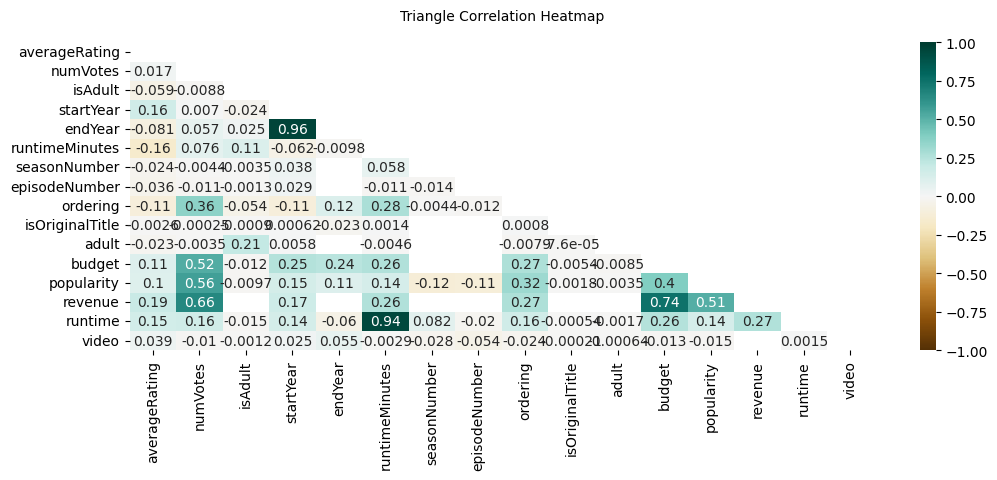

In [ ]:
plt.figure(figsize=(12, 4))
mask = np.triu(np.ones_like(train.corr(), dtype=np.bool))
heatmap = sns.heatmap(train.corr(),vmin=-1,vmax=1, mask=mask, annot=True, cmap='BrBG')
_=heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':10}, pad=16)

In [ ]:
# Quizás es conveniente combinar variables que expresan lo mismo
def CombineColumns(X,lista):
  col1 = lista[0]
  col2 = lista[1]
  X['transition'] = X.apply(lambda row: row[col2] if (np.isnan(row[col1])) & (np.isnan(row[col2])==False) else row[col1], axis=1)
  X = X.drop(columns=[col1,col2]).rename(columns={'transition':col1})
  return X

# X_train = CombineColumns(X_train,['isAdult','adult'])
# X_train = CombineColumns(X_train,['runtime','runtimeMinutes'])
# X_train = CombineColumns(X_train,['language','original_language'])

### Distribución Average Rating para variables numéricas
(desagregado para cuando son o no NA)

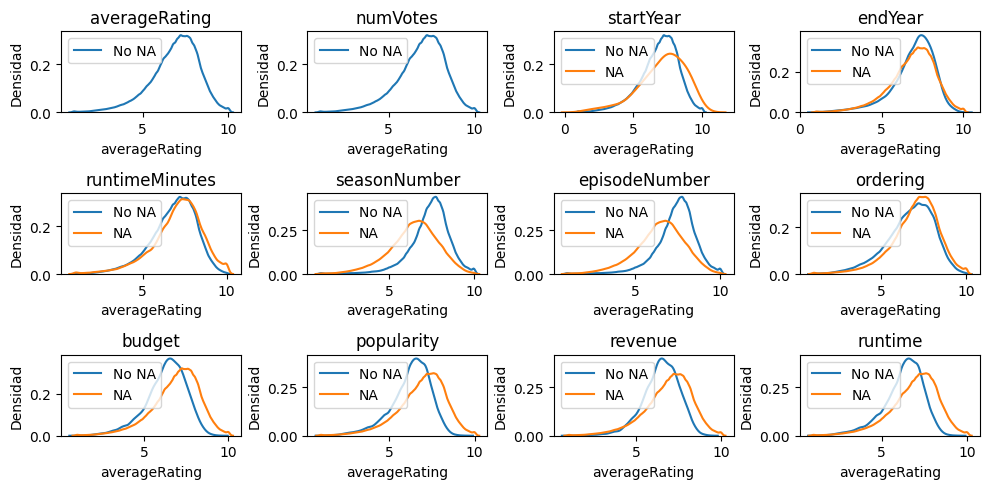

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

for i, column in enumerate(train_num):
    plt.subplot(3, len(train_num)//3, i + 1)

    df_notna = train[train[column].notna()]
    df_na = train[train[column].isna()]

    sns.kdeplot(data=df_notna, x='averageRating', label='No NA')
    sns.kdeplot(data=df_na, x='averageRating', label='NA')
    plt.xlabel('averageRating')
    plt.ylabel('Densidad')
    plt.title(f'{column}')

    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

result_df = pd.DataFrame(columns=['Variable', 'Media_No_NA', 'Media_NA'])
for column in train_num:
    mean_no_na = train[train[column].notna()]['averageRating'].mean()
    mean_na = train[train[column].isna()]['averageRating'].mean()
    result_df = result_df.append({'Variable': column, 'Media_No_NA': mean_no_na, 'Media_NA': mean_na}, ignore_index=True)
print(f"Media de Average Rating por variable: \n {result_df}")

<ipython-input-19-bb54fd969916>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Variable': column, 'Media_No_NA': mean_no_na, 'Media_NA': mean_na}, ignore_index=True)
<ipython-input-19-bb54fd969916>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Variable': column, 'Media_No_NA': mean_no_na, 'Media_NA': mean_na}, ignore_index=True)
<ipython-input-19-bb54fd969916>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Variable': column, 'Media_No_NA': mean_no_na, 'Media_NA': mean_na}, ignore_index=True)
<ipython-input-19-bb54fd969916>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

Media de Average Rating por variable: 
           Variable  Media_No_NA  Media_NA
0    averageRating     6.881764       NaN
1         numVotes     6.881764       NaN
2        startYear     6.881721  7.130588
3          endYear     6.943248  6.879925
4   runtimeMinutes     6.821831  7.048603
5     seasonNumber     7.394297  6.465271
6    episodeNumber     7.394297  6.465271
7         ordering     6.697012  6.994586
8           budget     6.287340  6.888414
9       popularity     6.273588  6.912736
10         revenue     6.463805  6.885732
11         runtime     6.281008  6.911289


<ipython-input-19-bb54fd969916>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Variable': column, 'Media_No_NA': mean_no_na, 'Media_NA': mean_na}, ignore_index=True)


### Correlación Average Rating con variables numéricas

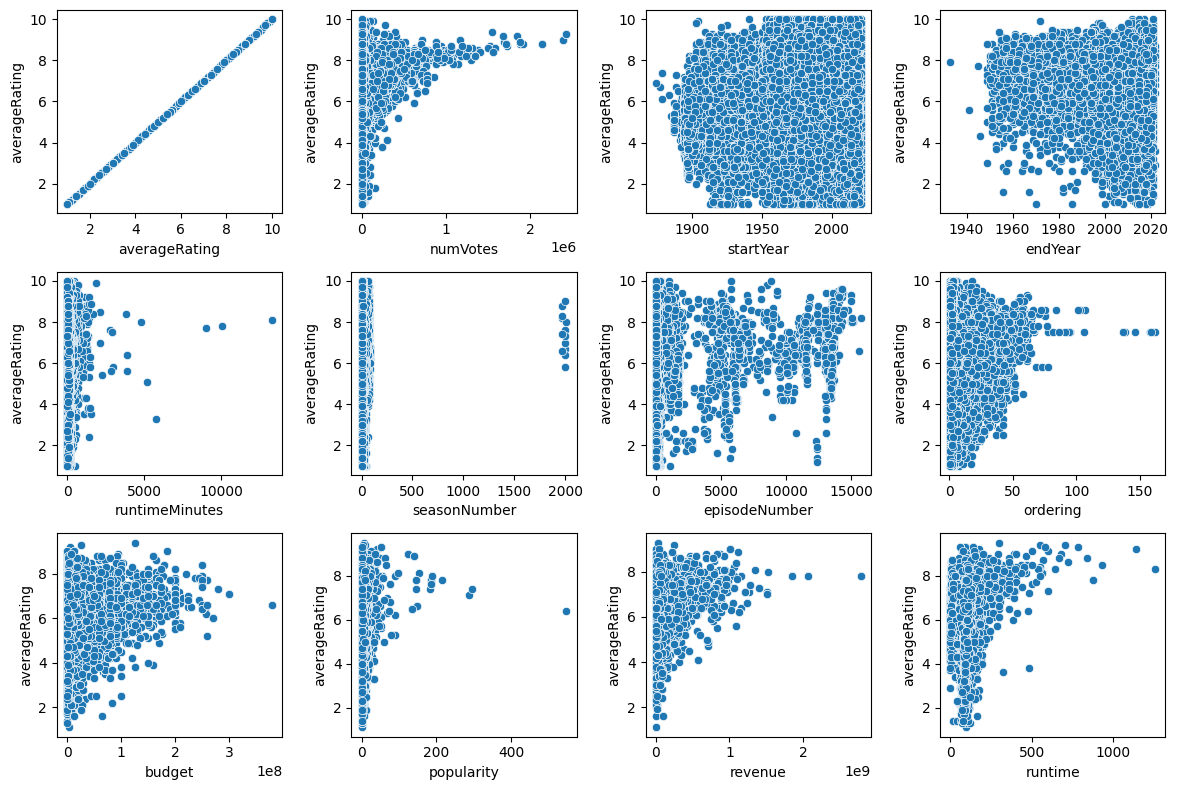

In [ ]:
plt.figure(figsize=(12, 8))
for i, variable in enumerate(train_num):
    plt.subplot(3, len(train_num)//3, i + 1)  #ajustar el número de filas y columnas
    sns.scatterplot(x=variable, y='averageRating', data=train)
    # plt.title(f'Scatter Plot de {variable} vs. averageRating')

plt.tight_layout()
plt.show()

In [ ]:
print(len(train[train['episodeNumber']>5000]))
print(len(train[train['episodeNumber'].isna()==False]))
print(len(train['episodeNumber']))
print(len(train[train['seasonNumber']>1500]))
print(train[train['episodeNumber']>5000]['titleType'].unique())
print(train[train['seasonNumber']>1500]['titleType'].unique())
print(train[train['titleType']!='tvEpisode'][train['seasonNumber'].isna()==False]['seasonNumber']) #Si no es tvEpisode, entonces no tiene seasonNumber
print(train[train['titleType']!='tvEpisode'][train['episodeNumber'].isna()==False]['episodeNumber']) #Si no es tvEpisode, entonces no tiene episodeNumber

1524
438243
977541
13
['tvEpisode']
['tvEpisode']
Series([], Name: seasonNumber, dtype: float64)


<ipython-input-13-6aa41cff4b23>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(train[train['titleType']!='tvEpisode'][train['seasonNumber'].isna()==False]['seasonNumber']) #Si no es tvEpisode, entonces no tiene seasonNumber


Series([], Name: episodeNumber, dtype: float64)


<ipython-input-13-6aa41cff4b23>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(train[train['titleType']!='tvEpisode'][train['episodeNumber'].isna()==False]['episodeNumber']) #Si no es tvEpisode, entonces no tiene episodeNumber


### Distribución Average Rating para variables categóricas


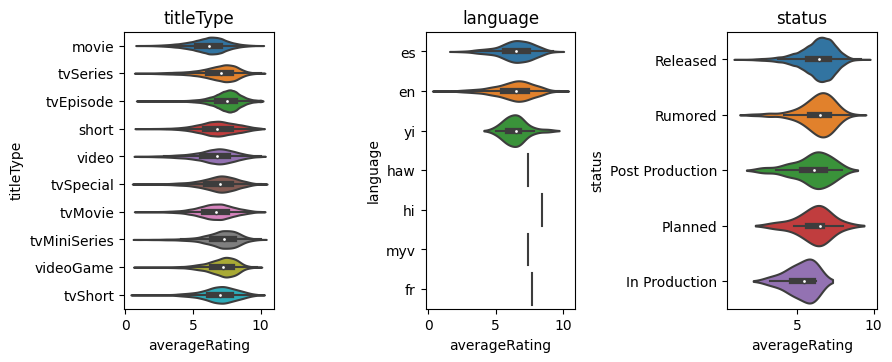

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 10))

for i, column in enumerate(train_violin_cat):
    plt.subplot(3, len(train_cat)//2, i + 1)
    sns.violinplot(x='averageRating', y=column, data=train)
    plt.xlabel('averageRating')
    plt.ylabel(column)
    plt.title(f'{column}')

plt.tight_layout()
plt.show()

In [115]:
print("Media AverageRating por categoría:")
for column in train_violin_cat:
    print(train.groupby(column)["averageRating"].mean(), "\n")

Media AverageRating por categoría:
titleType
movie           6.108876
short           6.780287
tvEpisode       7.394307
tvMiniSeries    7.083426
tvMovie         6.610029
tvSeries        6.802332
tvShort         6.898454
tvSpecial       6.783142
video           6.563740
videoGame       7.011952
Name: averageRating, dtype: float64 

language
en     6.31155
es     6.44635
fr     7.70000
haw    7.40000
hi     8.40000
myv    7.40000
yi     6.43200
Name: averageRating, dtype: float64 

status
In Production      5.242857
Planned            6.083333
Post Production    5.947778
Released           6.274493
Rumored            6.277273
Name: averageRating, dtype: float64 



In [116]:
print("Distribución categorías por variable:")
for column in train_violin_cat:
    print(f"{column} \n {train[column].value_counts(normalize=True, dropna=False)} \n")

Distribución categorías por variable:
titleType 
 tvEpisode       0.448326
movie           0.241080
short           0.114487
tvSeries        0.066576
video           0.056354
tvMovie         0.041278
videoGame       0.010982
tvMiniSeries    0.009986
tvSpecial       0.009011
tvShort         0.001919
Name: titleType, dtype: float64 

language 
 NaN    0.998344
en     0.001346
es     0.000280
yi     0.000026
haw    0.000001
hi     0.000001
myv    0.000001
fr     0.000001
Name: language, dtype: float64 

status 
 NaN                0.951614
Released           0.048042
Rumored            0.000225
Post Production    0.000092
In Production      0.000014
Planned            0.000012
Name: status, dtype: float64 



### Distribución Average Rating para variables booleanas

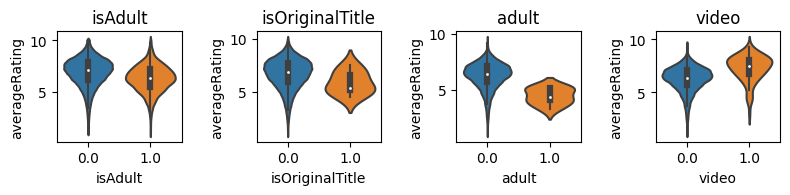

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))

for i, column in enumerate(train_bool):
    plt.subplot(3, len(train_cat)//2, i + 1)
    sns.violinplot(x=column, y='averageRating', data=train)
    plt.xlabel(column)
    plt.ylabel('averageRating')
    plt.title(f'{column}')

plt.tight_layout()
plt.show()

In [ ]:
print("Media AverageRating por categoría:")
for column in train_bool:
    print(train.groupby(column)["averageRating"].mean(), "\n")

Media AverageRating por categoría:
isAdult
0.0    6.893230
1.0    6.286245
Name: averageRating, dtype: float64 

isOriginalTitle
0.0    6.697028
1.0    5.857143
Name: averageRating, dtype: float64 

adult
0.0    6.273946
1.0    4.460000
Name: averageRating, dtype: float64 

video
0.0    6.271623
1.0    7.294505
Name: averageRating, dtype: float64 



In [ ]:
print("Distribución categorías por variable:")
for column in train_bool:
    print(f"{column} \n {train[column].value_counts(normalize=True, dropna=False)} \n")

Distribución categorías por variable:
isAdult 
 0.0    0.98111
1.0    0.01889
Name: isAdult, dtype: float64 

isOriginalTitle 
 NaN    0.620862
0.0    0.379131
1.0    0.000007
Name: isOriginalTitle, dtype: float64 

adult 
 NaN    0.951542
0.0    0.048448
1.0    0.000010
Name: adult, dtype: float64 

video 
 NaN    0.951543
0.0    0.048364
1.0    0.000093
Name: video, dtype: float64 



# **Análisis Predictivo**

Para realizar la predicción del *'average_rating'* del dataset de test, se realizará lo siguiente:

1.   **Selección variables**
2.   **Identificación de variables por tipo de dato**
3.   **Pipeline de transformación de variables (imputación, encoding, escalado)**
4.   **Elección del modelo a utilizar**
5.   **Elaboración de Grilla con hiperparámetros customizados**
6.   **Aplicación del RandomizedSearchCV (opcional)**
7.   **Reconocimiento de feature importance**

Luego, si el modelo resulta mejor que el modelo baseline:

1.   **Guardado del mejor pipeline para futuras predicciones**
2.   **Entrenamiento del mejor modelo con X completo**
3.   **Predicción de test y exportación de resultados**

### Variables con pocos NA's (Baseline)

In [11]:
X = train[['numVotes','titleType','isAdult','startYear','runtimeMinutes','genres_x']]
y = train['averageRating']

txt = ['tagline'] if 'tagline' in X.columns else []
bool = [c for c in X.columns if X[c].nunique() <= 3]
cat = [c for c in X.columns if X[c].dtype == 'O' and c not in bool]
num = [c for c in X.columns if X[c].dtype != 'O' and c not in bool]

print(f"Texto: {txt} \n Booleanas: {bool} \n Categóricas: {cat} \n Numéricas: {num} \n")
print("Total variables:",len(txt)+len(bool)+len(cat)+len(num))

Texto: [] 
 Booleanas: ['isAdult'] 
 Categóricas: ['titleType', 'genres_x'] 
 Numéricas: ['numVotes', 'startYear', 'runtimeMinutes'] 

Total variables: 6


In [12]:
# cachedir = mkdtemp() #crea directorio de almacenamiento en caché (para que GridSearch sea más rápido)
pipe = Pipeline([

    # Missing values -----------------------------------------------------------
    ('cat_imputer', CategoricalImputer(fill_value="unk", return_object=True, ignore_format=True, variables=cat)),
    ('num_missing_ind', AddMissingIndicator(missing_only=True, variables=num)),
    ('num_imputer', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='mean'),variables = num)),
    ('bool_imputer', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),variables = bool)),

    # Categorical encoding -----------------------------------------------------
    ('cat_encoder', CountFrequencyEncoder(encoding_method='frequency',variables=cat)),

 ]) #agregar Pipeline(steps,memory=cachedir) si se quiere hacer lo del directorio en caché

XGBoost

In [22]:
# Aplicación Transformaciones
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=22,shuffle=True)
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
for var in cat:
  X_val[var] = X_val[var].replace(np.nan,0) #computa con un 0 las frecuencias de las categorías que están en val pero no en train (la función las deja como NA)

# Aplicación Modelo
modelo = XGBRegressor(
        n_estimators=200,
        learning_rate=0.3,
        max_depth=6,
        random_state=22)

modelo.fit(X_train,y_train)
y_pred = modelo.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) genres_x.
  warnings.warn(


0.3384199882905987

Random Forest

In [7]:
# Aplicación Transformaciones
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=22,shuffle=True)
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
for var in cat:
  X_val[var] = X_val[var].replace(np.nan,0)

# Aplicación Modelo
modelo = RandomForestRegressor(
            n_estimators=200, min_samples_leaf=1, max_features=1,random_state=22)

modelo.fit(X_train,y_train)
y_pred = modelo.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) genres_x.
  warnings.warn(


0.3643083384400255

In [ ]:
importances = rf_pipe.named_steps['reg'].feature_importances_
feature_names = rf_pipe[-2].get_feature_names_out()

df_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
importancia = df_importance.sort_values("importance", ascending=False)

importancia[importancia['importance'] >= 0.01]

Support Vector Machine

In [ ]:
# Aplicación Transformaciones
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=22,shuffle=True)
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
for var in cat:
  X_val[var] = X_val[var].replace(np.nan,0)

# Aplicación Modelo
# modelo = SVR(kernel='poly', degree=3, gamma='scale')
modelo = SVR()

modelo.fit(X_train,y_train)
y_pred = modelo.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) genres_x.
  warnings.warn(


Red Neuronal

In [13]:
# Aplicación Transformaciones
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=22,shuffle=True)
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
for var in cat:
  X_val[var] = X_val[var].replace(np.nan,0)

# Aplicación Modelo
modelo = MLPRegressor(random_state=22)

modelo.fit(X_train,y_train)
y_pred = modelo.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) genres_x.
  warnings.warn(


0.07466889897948104

### Sin Variables Complejas

In [33]:
X = train.drop(columns=['averageRating','production_companies','production_countries','tagline'])
y = train['averageRating']

txt = ['tagline'] if 'tagline' in X.columns else []
bool = [c for c in X.columns if X[c].nunique() <= 3]
cat = [c for c in X.columns if X[c].dtype == 'O' and c not in bool]
num = [c for c in X.columns if X[c].dtype != 'O' and c not in bool]

print(f"Texto: {txt} \n Booleanas: {bool} \n Categóricas: {cat} \n Numéricas: {num} \n")
print("Total variables:",len(txt)+len(bool)+len(cat)+len(num))

Texto: [] 
 Booleanas: ['isAdult', 'isOriginalTitle', 'adult', 'video'] 
 Categóricas: ['titleType', 'genres_x', 'directors', 'writers', 'language', 'attributes', 'genres_y', 'original_language', 'status'] 
 Discretas: [] 
 Numéricas: ['numVotes', 'startYear', 'endYear', 'runtimeMinutes', 'seasonNumber', 'episodeNumber', 'ordering', 'budget', 'popularity', 'revenue', 'runtime'] 

Total variables: 24


In [34]:
# cachedir = mkdtemp() #crea directorio de almacenamiento en caché (para que GridSearch sea más rápido)
pipe = Pipeline([

    # Missing values -----------------------------------------------------------
    ('cat_imputer', CategoricalImputer(fill_value="unk", return_object=True, ignore_format=True, variables=cat)),
    ('num_missing_ind', AddMissingIndicator(missing_only=True, variables=num)),
    ('num_imputer', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='mean'),variables = num)),
    ('bool_imputer', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),variables = bool)),

    # Categorical encoding -----------------------------------------------------
    ('cat_encoder', CountFrequencyEncoder(encoding_method='frequency',variables=cat)),

 ]) #agregar Pipeline(steps,memory=cachedir) si se quiere hacer lo del directorio en caché

XGBoost

In [35]:
# Aplicación Transformaciones
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=22,shuffle=True)
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
for var in cat:
  X_val[var] = X_val[var].replace(np.nan,0)

# Aplicación Modelo
modelo = XGBRegressor(
    n_estimators=200, learning_rate=0.3, max_depth=6, random_state=22)

modelo.fit(X_train,y_train)
y_pred = modelo.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) genres_x, directors, writers, attributes, genres_y, original_language.
  warnings.warn(


0.3730053093581469

Random Forest

In [ ]:
# Aplicación Transformaciones
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=22,shuffle=True)
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
for var in cat:
  X_val[var] = X_val[var].replace(np.nan,0)

# Aplicación Modelo
modelo = RandomForestRegressor(
            n_estimators=200, min_samples_leaf=1, max_features=1,random_state=22)

modelo.fit(X_train,y_train)
y_pred = modelo.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

### Sin Variables Complejas con Transformaciones Tuneadas

In [36]:
X = train.drop(columns=['averageRating','production_companies','production_countries','tagline'])
y = train['averageRating']

txt = ['tagline'] if 'tagline' in X.columns else []
bool = [c for c in X.columns if X[c].nunique() <= 3]
cat = [c for c in X.columns if X[c].dtype == 'O' and c not in bool]
num = [c for c in X.columns if X[c].dtype != 'O' and c not in bool]

print(f"Texto: {txt} \n Booleanas: {bool} \n Categóricas: {cat} \n Numéricas: {num} \n")
print("Total variables:",len(txt)+len(bool)+len(cat)+len(num))

Texto: [] 
 Booleanas: ['isAdult', 'isOriginalTitle', 'adult', 'video'] 
 Categóricas: ['titleType', 'genres_x', 'directors', 'writers', 'language', 'attributes', 'genres_y', 'original_language', 'status'] 
 Discretas: [] 
 Numéricas: ['numVotes', 'startYear', 'endYear', 'runtimeMinutes', 'seasonNumber', 'episodeNumber', 'ordering', 'budget', 'popularity', 'revenue', 'runtime'] 

Total variables: 24


In [46]:
# cachedir = mkdtemp() #crea directorio de almacenamiento en caché (para que GridSearch sea más rápido)
pipe = Pipeline([

    # Missing values -----------------------------------------------------------
    ('cat_imputer', CategoricalImputer(fill_value="unk", return_object=True, variables=cat)),
    ('num_missing_ind', AddMissingIndicator(missing_only=True, variables=num)),
    # ('num_imputer', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='mean'),variables = num)),
    # ('num_imputer', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='median'),variables = num)),
    ('num_imputer', EndTailImputer(imputation_method='iqr', tail='right', fold=3, variables=num)),
    ('bool_imputer', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),variables = bool)),

    # Categorical encoding -----------------------------------------------------
    # ('cat_rare_labels', RareLabelEncoder(tol=500 / X_train.shape[0], n_categories=1, replace_with="otros", variables=cat)),
    ('cat_encoder', CountFrequencyEncoder(encoding_method='frequency',variables=cat)),
    # ('cat_encoder', CountFrequencyEncoder(encoding_method='count',variables=cat)),
    # ('cat_encoder', OrdinalEncoder(encoding_method='ordered', unseen="encode", variables=cat)), #sirve igual que OneHotEncoder SOLO en modelos basados en árboles

    # Transformations ----------------------------------------------------------
    # ('interactions', RelativeFeatures(variables=[], reference=[], func=[])),
    # ('polynomial', PowerTransformer(exp=2, variables=[])),
    # NOTE ver sklearn.preprocessing.PolynomialFeatures

 ]) #agregar Pipeline(steps,memory=cachedir) si se quiere hacer lo del directorio en caché

In [ ]:
# Otras Transformaciones que se podrían probar
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn_pandas import DataFrameMapper

X_train['genres_x'] = X_train['genres_x'].replace('0',np.nan)
X_train['genres_x'] = X_train['genres_x'].replace(np.nan,'unk')
X_train['genres_x'] = X_train['genres_x'].apply(lambda x: x.split(',') if pd.notna(x) else np.nan)
generos = list(set(genero for lista_generos in X_train['genres_x'] for genero in lista_generos))
binarizer_x = DataFrameMapper([("genres_x", MultiLabelBinarizer(classes=generos)),], df_out=True, default=None)
X_train = binarizer_x.fit_transform(X_train)
X_train.head()

XGBoost

In [47]:
# Aplicación Transformaciones
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=22,shuffle=True)
X_train = pipe.fit_transform(X_train, y_train)
X_val = pipe.transform(X_val)
for var in cat:
  X_val[var] = X_val[var].replace(np.nan,0)

# Aplicación Modelo
# modelo = XGBRegressor(
#         n_estimators=300, learning_rate=0.1, max_depth=15, random_state=22)

modelo = XGBRegressor(
    n_estimators=200, learning_rate=0.3, max_depth=6, random_state=22)

modelo.fit(X_train,y_train)
y_pred = modelo.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

# original: R2=0.3730053093581469
# mod 'num_imputer', SimpleImputer('median'): R2=0.3735499758279003
# mod 'num_imputer', EndTailImputer: R2=0.3760569218349431 (queda este)
# mod 'cat_encoder', CountFrequencyEncoder(encoding_method='count'): R2=0.3760569218349431 (queda original)
# mod 'cat_encoder', OrdinalEncoder: R2=-3.6931459746688367
# add 'cat_rare_labels', RareLabelEncoder: R2=0.36256279307508765 (no se agrega)


0.36256279307508765

Random Forest

In [ ]:
# Aplicación Transformaciones
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=22,shuffle=True)
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
for var in cat:
  X_val[var] = X_val[var].replace(np.nan,0)

# Aplicación Modelo
modelo = RandomForestRegressor(
            n_estimators=250, min_samples_leaf=5, max_features=10,
            oob_score=False, random_state=22)

modelo.fit(X_train,y_train)
y_pred = modelo.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

# original: R2=


### Sin Variables Complejas con Hiperparámetros Tuneados

In [5]:
X = train.drop(columns=['averageRating','production_companies','production_countries','tagline'])
y = train['averageRating']

txt = ['tagline'] if 'tagline' in X.columns else []
bool = [c for c in X.columns if X[c].nunique() <= 3]
cat = [c for c in X.columns if X[c].dtype == 'O' and c not in bool]
num = [c for c in X.columns if X[c].dtype != 'O' and c not in bool]

print(f"Texto: {txt} \n Booleanas: {bool} \n Categóricas: {cat} \n Numéricas: {num} \n")
print("Total variables:",len(txt)+len(bool)+len(cat)+len(num))

Texto: [] 
 Booleanas: ['isAdult', 'isOriginalTitle', 'adult', 'video'] 
 Categóricas: ['titleType', 'genres_x', 'directors', 'writers', 'language', 'attributes', 'genres_y', 'original_language', 'status'] 
 Discretas: [] 
 Numéricas: ['numVotes', 'startYear', 'endYear', 'runtimeMinutes', 'seasonNumber', 'episodeNumber', 'ordering', 'budget', 'popularity', 'revenue', 'runtime'] 

Total variables: 24


In [6]:
# cachedir = mkdtemp() #crea directorio de almacenamiento en caché (para que GridSearch sea más rápido)
pipe = Pipeline([

    # Missing values -----------------------------------------------------------
    ('cat_imputer', CategoricalImputer(fill_value="unk", return_object=True, variables=cat)),
    ('num_missing_ind', AddMissingIndicator(missing_only=True, variables=num)),
    ('num_imputer', EndTailImputer(imputation_method='iqr', tail='right', fold=3, variables=num)),
    ('bool_imputer', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),variables = bool)),

    # Categorical encoding -----------------------------------------------------
    ('cat_encoder', CountFrequencyEncoder(encoding_method='frequency',variables=cat)),

 ]) #agregar Pipeline(steps,memory=cachedir) si se quiere hacer lo del directorio en caché

XGBoost

Con RandomizedSearch

In [7]:
param_grid = {
    'n_estimators': [200,300],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [10,15,20],
    'gamma': [0,1],
    'reg_lambda': [0,2,3,4,5,6],
    'reg_alpha': [0,2,4,6]
}

In [8]:
#NO se divide en Train y Val porque el RandomizedSearch usa Cross-Validation

# Aplicación Transformaciones
X = pipe.fit_transform(X)

# Aplicación Modelo
modelo = XGBRegressor(
        n_estimators=300, learning_rate=0.1, max_depth=20, random_state=22)

rand = RandomizedSearchCV(modelo,param_grid,n_iter=3,scoring='r2',cv=2,random_state=22)
rand.fit(X,y)
rmtree(cachedir) #borra el directorio temporal en caché

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 27.20s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  X, fitted_transformer = fit_transform_one_cached(
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 41.05s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  X, fitted_transformer = fit_transform_one_cached(
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 34.10s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is proba

In [9]:
#Muestra resultados de grid o rand Search
results = pd.DataFrame(rand.cv_results_)[['params','mean_test_score','rank_test_score']]
results.sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
2,"{'reg_lambda': 2, 'reg_alpha': 0, 'max_depth':...",0.449230,1
1,"{'reg_lambda': 2, 'reg_alpha': 0, 'max_depth':...",0.430422,2
0,"{'reg_lambda': 0, 'reg_alpha': 2, 'max_depth':...",0.420410,3


In [14]:
rand.cv_results_

{'mean_fit_time': array([ 41.28244829, 757.62135434, 111.40021479]),
 'std_fit_time': array([ 5.82323122, 18.04745269,  0.61992514]),
 'mean_score_time': array([ 11.01766407, 129.63286591,  33.15425169]),
 'std_score_time': array([0.14545619, 0.1003902 , 0.87193048]),
 'param_reg_lambda': masked_array(data=[0, 2, 2],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_reg_alpha': masked_array(data=[2, 0, 0],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[10, 20, 15],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.1, 0.01, 0.1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'reg_lambda': 0,
   'reg_alpha': 2,
   'max_depth': 10,
   'learning_rate': 0.1},
  {'reg_lambda': 2, 'reg_alpha': 0, 'max_depth': 

In [10]:
# Obtener el mejor modelo
mejor_modelo = rand.best_estimator_
print("Mejor modelo:")
print(mejor_modelo)

Mejor modelo:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=22, ...)


Sin RandomizedSearch ("a mano")

In [17]:
# Aplicación Transformaciones
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=22,shuffle=True)
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
for var in cat:
  X_val[var] = X_val[var].replace(np.nan,0)

# Aplicación Modelo
modelo = XGBRegressor(
        n_estimators=300, learning_rate=0.1, max_depth=15, reg_lambda=4, random_state=22)

modelo.fit(X_train,y_train)
y_pred = modelo.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

# original (params default): R2=0.3760569218349431
# n_estimators=300, learning_rate=0.1, max_depth=15: R2=0.4801958841065018
# n_estimators=300, learning_rate=0.1, max_depth=20: R2=0.4437767704181339
# n_estimators=300, learning_rate=0.1, max_depth=10: R2=0.4324150870449379
# n_estimators=300, learning_rate=0.01, max_depth=15: R2=0.43125924430238916
# n_estimators=300, learning_rate=0.05, max_depth=15: R2=0.4784382254299179
# n_estimators=300, learning_rate=0.15, max_depth=15: R2=0.47399591249717976
# gamma=1: R2=0.4626361466830732
# reg_lambda=0: R2=0.47350737850120417
# reg_lambda=2: R2=0.48186454366058595
# reg_lambda=3: R2=0.48205758927716247
# reg_lambda=4: R2=0.48470948112372336
# reg_lambda=5: R2=0.48102181212496053
# reg_lambda=6: R2=0.4811903713017869
# reg_lambda=0, reg_alpha=2: R2=0.48176103621296706
# reg_lambda=0, reg_alpha=4: R2=0.482444530083027
# reg_lambda=0, reg_alpha=6: R2=0.4787888913108943

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) genres_x, directors, writers, attributes, genres_y, original_language.
  warnings.warn(


0.48102181212496053

Random Forest

In [ ]:
# Aplicación Transformaciones
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=22,shuffle=True)
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
for var in cat:
  X_val[var] = X_val[var].replace(np.nan,0)

# Aplicación Modelo
modelo = RandomForestRegressor(
            n_estimators=250, min_samples_leaf=5, max_features=3, random_state=22)

modelo.fit(X_train,y_train)
y_pred = modelo.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

# original (params default): R2=
# n_estimators=250, min_samples_leaf=5, max_features=3, random_state=22): R2=0.39162884852027646


### Con Variables Complejas y Extras

In [98]:
X = train.drop(columns=['averageRating','tagline'])
y = train['averageRating']

X['writers'] = X['writers'].replace(np.nan,'unk')
X['cant_writers'] = X['writers'].apply(lambda x: x.count(',')+1 if 'unk' not in x else np.nan)
X['directors'] = X['directors'].replace(np.nan,'unk')
X['cant_directors'] = X['directors'].apply(lambda x: x.count(',')+1 if 'unk' not in x else np.nan)
X['genres_x'] = X['genres_x'].replace(np.nan,'unk')
X['cant_genres_x'] = X['genres_x'].apply(lambda x: x.count(',')+1 if 'unk' not in x else np.nan)
# X['genres_y'] = X['genres_y'].replace(np.nan,'unk')
# X['cant_genres_y'] = X['genres_y'].apply(lambda x: x.count('name') if 'unk' not in x else np.nan)
# X['production_companies'] = X['production_companies'].replace(np.nan,'unk')
# X['cant_production_companies'] = X['production_companies'].apply(lambda x: x.count('name') if 'unk' not in x else np.nan)
# X['production_countries'] = X['production_countries'].replace(np.nan,'unk')
# X['cant_production_countries'] = X['production_countries'].apply(lambda x: x.count('name') if 'unk' not in x else np.nan)
X = X.drop(columns=['production_companies','production_countries'])

test['writers'] = test['writers'].replace(np.nan,'unk')
test['cant_writers'] = test['writers'].apply(lambda x: x.count(',')+1 if 'unk' not in x else np.nan)
test['directors'] = test['directors'].replace(np.nan,'unk')
test['cant_directors'] = test['directors'].apply(lambda x: x.count(',')+1 if 'unk' not in x else np.nan)
test['genres_x'] = test['genres_x'].replace(np.nan,'unk')
test['cant_genres_x'] = test['genres_x'].apply(lambda x: x.count(',')+1 if 'unk' not in x else np.nan)
# test['genres_y'] = test['genres_y'].replace(np.nan,'unk')
# test['cant_genres_y'] = test['genres_y'].apply(lambda x: x.count('name') if 'unk' not in x else np.nan)
# test['production_companies'] = test['production_companies'].replace(np.nan,'unk')
# test['cant_production_companies'] = test['production_companies'].apply(lambda x: x.count('name') if 'unk' not in x else np.nan)
# test['production_countries'] = test['production_countries'].replace(np.nan,'unk')
# test['cant_production_countries'] = test['production_countries'].apply(lambda x: x.count('name') if 'unk' not in x else np.nan)
test = test.drop(columns=['production_companies','production_countries'])


txt = ['tagline'] if 'tagline' in X.columns else []
bool = [c for c in X.columns if X[c].nunique() <= 2]
cat = [c for c in X.columns if X[c].dtype == 'O' and c not in bool]
num = [c for c in X.columns if X[c].dtype != 'O' and c not in bool]

print(f"Texto: {txt} \n Booleanas: {bool} \n Categóricas: {cat} \n Numéricas: {num} \n")
print("Total variables:",len(txt)+len(bool)+len(cat)+len(num))

# X['titleType_ohe']=X['titleType'] #Duplica variable titleType por si desp quiero probar a hacerle OHE
# test['titleType_ohe']=test['titleType']

Texto: [] 
 Booleanas: ['isAdult', 'isOriginalTitle', 'adult', 'video'] 
 Categóricas: ['titleType', 'genres_x', 'directors', 'writers', 'language', 'attributes', 'genres_y', 'original_language', 'status'] 
 Discretas: ['cant_genres_x'] 
 Numéricas: ['numVotes', 'startYear', 'endYear', 'runtimeMinutes', 'seasonNumber', 'episodeNumber', 'ordering', 'budget', 'popularity', 'revenue', 'runtime', 'cant_writers', 'cant_directors', 'cant_genres_x'] 

Total variables: 28


In [89]:
# cachedir = mkdtemp() #crea directorio de almacenamiento en caché (para que GridSearch sea más rápido)
pipe = Pipeline([

    # Missing values -----------------------------------------------------------
    ('cat_imputer', CategoricalImputer(fill_value="unk", return_object=True, variables=cat)),
    ('num_missing_ind', AddMissingIndicator(missing_only=True, variables=num)),
    ('num_imputer', EndTailImputer(imputation_method='iqr', tail='right', fold=3, variables=num)),
    ('bool_imputer', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),variables = bool)),

    # Categorical encoding -----------------------------------------------------
    ('cat_encoder', CountFrequencyEncoder(encoding_method='frequency',variables=cat)),
    # ('ohe_titleType', OneHotEncoder(variables='titleType_ohe')),

 ]) #agregar Pipeline(steps,memory=cachedir) si se quiere hacer lo del directorio en caché

XGBoost

In [ ]:
#ESTO ES SIN RANDOMIZEDSEARCH. SI FUNCIONA EL RANDOMIZED, ENTONCES ELIMINAR ESTO

# Aplicación Transformaciones
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=22,shuffle=True)
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
for var in cat:
  X_val[var] = X_val[var].replace(np.nan,0)

# Aplicación Modelo
modelo = XGBRegressor(
        n_estimators=300, learning_rate=0.1, max_depth=15, reg_lambda=4, random_state=22)

modelo.fit(X_train,y_train)
y_pred = modelo.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

# original: R2=0.48470948112372336
# add variables complejas pero no nuevas: R2=0.4843049526657206 (no aporta)
# add 'cant_writers': R2=0.4862419641456729
# add 'cant_directors': R2=0.4841633241942328 (no aporta)
# add 'cant_genres_x': R2 (sin directors)=0.48516905681631173, R2 (con todas)=0.48861531914275924
# add 'cant_genres_y': R2 (sin directors)=0.48643646885704905, R2 (con todas)=0.4870971219150564 (no aporta)
# add 'cant_production_companies': R2 (sin directors)=0.486860505372291, R2 (sin genres_y)=0.48801284520862465, R2 (con todas)=0.48821951587983414 (no aporta)
# add 'cant_production_countries': R2 (con todas)=0.4864387082999486 (no aporta)
# add ohe_titleType: R2=0.4838544781221815

Random Forest

In [ ]:
# cachedir = mkdtemp() #crea directorio de almacenamiento en caché (para que GridSearch sea más rápido)
pipe = Pipeline([

    # Missing values -----------------------------------------------------------
    ('cat_imputer', CategoricalImputer(fill_value="unk", return_object=True, variables=cat)),
    ('num_missing_ind', AddMissingIndicator(missing_only=True, variables=num)),
    ('num_imputer', EndTailImputer(imputation_method='iqr', tail='right', fold=3, variables=num)),
    ('bool_imputer', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),variables = bool)),

    # Categorical encoding -----------------------------------------------------
    ('cat_encoder', CountFrequencyEncoder(encoding_method='frequency',variables=cat)),
    # ('ohe_titleType', OneHotEncoder(variables='titleType_ohe')),

 ]) #agregar Pipeline(steps,memory=cachedir) si se quiere hacer lo del directorio en caché

In [ ]:
# Evaluación con set de validación
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=22,shuffle=True)
rf_pipe.fit(X_train,y_train)
y_pred = rf_pipe.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

#Los R2 se calculan teniendo en cuenta las variables agregadas en pasos anteriores que subieron el R2 anterior
#sin variables nuevas: R2=0.4508399482735148
#'cant_writers': R2=0.45504920290755013
#'cant_directors': R2=0.45576256847547747
#'cant_genres_x': R2=0.45851508007897634
#'cant_genres_y': R2=0.4584821415437036
#'cant_production_companies','cant_production_countries': R2=0.459661514821623, R2cv=0.44653006183760996
#'cant_production_companies','cant_production_countries' (reg_lambda=0, reg_alpha=2): R2=0.45783537667184304, R2cv=0.44893011228393204
#ohe_titleType: R2=0.4591464696854506, R2cv=0.4466644985847745
#ohe_titleType (reg_lambda=0, reg_alpha=2): R2=0.46102900660694457, R2cv=0.44841263090529493

0.4591464696854506

# **Subir Resultados a Kaggle**

### Baseline

In [121]:
X = train[['numVotes','titleType','isAdult','startYear','runtimeMinutes','genres_x']]
y = train['averageRating']
test_sub = test[['numVotes','titleType','isAdult','startYear','runtimeMinutes','genres_x']]

txt = ['tagline'] if 'tagline' in X.columns else []
bool = [c for c in X.columns if X[c].nunique() <= 3]
cat = [c for c in X.columns if X[c].dtype == 'O' and c not in bool]
num = [c for c in X.columns if X[c].dtype != 'O' and c not in bool]

print(f"Texto: {txt} \n Booleanas: {bool} \n Categóricas: {cat} \n Numéricas: {num} \n")
print("Total variables:",len(txt)+len(bool)+len(cat)+len(num))

Texto: [] 
 Booleanas: ['isAdult'] 
 Categóricas: ['titleType', 'genres_x'] 
 Numéricas: ['numVotes', 'startYear', 'runtimeMinutes'] 

Total variables: 6


In [122]:
# cachedir = mkdtemp() #crea directorio de almacenamiento en caché (para que GridSearch sea más rápido)
pipe = Pipeline([

    # Missing values -----------------------------------------------------------
    ('cat_imputer', CategoricalImputer(fill_value="unk", return_object=True, ignore_format=True, variables=cat)),
    ('num_missing_ind', AddMissingIndicator(missing_only=True, variables=num)),
    ('num_imputer', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='mean'),variables = num)),
    ('bool_imputer', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),variables = bool)),

    # Categorical encoding -----------------------------------------------------
    ('cat_encoder', CountFrequencyEncoder(encoding_method='frequency',variables=cat)),

 ]) #agregar Pipeline(steps,memory=cachedir) si se quiere hacer lo del directorio en caché

In [124]:
# Aplicación Transformaciones
X = pipe.fit_transform(X)
test_sub = pipe.transform(test_sub)
for var in cat:
  test_sub[var] = test_sub[var].replace(np.nan,0)

# Medición Modelo
modelo = XGBRegressor(
        n_estimators=200,
        learning_rate=0.3,
        max_depth=6,
        random_state=22)

cv_scores = cross_val_score(modelo,X,y,cv=5)
print(f"Scores: {cv_scores} \n Mean Score: {cv_scores.mean()}")

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) genres_x.
  warnings.warn(


Scores: [0.33467293 0.33722041 0.33978638 0.3374875  0.33596507] 
 Mean Scores: 0.3370264585461794


In [125]:
# Aplicación Modelo
modelo.fit(X,y)
y_pred = modelo.predict(test_sub)

# Exporto los resultados
salida = pd.DataFrame(data={"averageRating": y_pred}).astype(str)
salida.index = test_sub.index
salida.to_csv("baseline.csv", sep=',',index=True,  index_label='Id')


### Mejor modelo


*   **Modelo**: XGBoost
*   **Variables**: Sin Complejas y con cant_writers, cant_directors y cant_genres_x
*   **Transformaciones**: Imputación numéricas con IQR, Imputación binarias con más frecuente y Encoder categóricas con frecuencia
*   **Hiperparámetros**: n_estimators=300, max_depth=15, learning_rate=0.1, reg_lambda(L2)=4


In [108]:
X = train.drop(columns=['averageRating','tagline'])
y = train['averageRating']
test_sub = test.drop(columns=['tagline'])

X['writers'] = X['writers'].replace(np.nan,'unk')
X['cant_writers'] = X['writers'].apply(lambda x: x.count(',')+1 if 'unk' not in x else np.nan)
X['directors'] = X['directors'].replace(np.nan,'unk')
X['cant_directors'] = X['directors'].apply(lambda x: x.count(',')+1 if 'unk' not in x else np.nan)
X['genres_x'] = X['genres_x'].replace(np.nan,'unk')
X['cant_genres_x'] = X['genres_x'].apply(lambda x: x.count(',')+1 if 'unk' not in x else np.nan)
# X['genres_y'] = X['genres_y'].replace(np.nan,'unk')
# X['cant_genres_y'] = X['genres_y'].apply(lambda x: x.count('name') if 'unk' not in x else np.nan)
# X['production_companies'] = X['production_companies'].replace(np.nan,'unk')
# X['cant_production_companies'] = X['production_companies'].apply(lambda x: x.count('name') if 'unk' not in x else np.nan)
# X['production_countries'] = X['production_countries'].replace(np.nan,'unk')
# X['cant_production_countries'] = X['production_countries'].apply(lambda x: x.count('name') if 'unk' not in x else np.nan)
X = X.drop(columns=['production_companies','production_countries'])

test_sub['writers'] = test_sub['writers'].replace(np.nan,'unk')
test_sub['cant_writers'] = test_sub['writers'].apply(lambda x: x.count(',')+1 if 'unk' not in x else np.nan)
test_sub['directors'] = test_sub['directors'].replace(np.nan,'unk')
test_sub['cant_directors'] = test_sub['directors'].apply(lambda x: x.count(',')+1 if 'unk' not in x else np.nan)
test_sub['genres_x'] = test_sub['genres_x'].replace(np.nan,'unk')
test_sub['cant_genres_x'] = test_sub['genres_x'].apply(lambda x: x.count(',')+1 if 'unk' not in x else np.nan)
# test_sub['genres_y'] = test_sub['genres_y'].replace(np.nan,'unk')
# test_sub['cant_genres_y'] = test_sub['genres_y'].apply(lambda x: x.count('name') if 'unk' not in x else np.nan)
# test_sub['production_companies'] = test_sub['production_companies'].replace(np.nan,'unk')
# test_sub['cant_production_companies'] = test_sub['production_companies'].apply(lambda x: x.count('name') if 'unk' not in x else np.nan)
# test_sub['production_countries'] = test_sub['production_countries'].replace(np.nan,'unk')
# test_sub['cant_production_countries'] = test_sub['production_countries'].apply(lambda x: x.count('name') if 'unk' not in x else np.nan)
test_sub = test_sub.drop(columns=['production_companies','production_countries'])


txt = ['tagline'] if 'tagline' in X.columns else []
bool = [c for c in X.columns if X[c].nunique() <= 2]
cat = [c for c in X.columns if X[c].dtype == 'O' and c not in bool]
num = [c for c in X.columns if X[c].dtype != 'O' and c not in bool]

print(f"Texto: {txt} \n Booleanas: {bool} \n Categóricas: {cat} \n Numéricas: {num} \n")
print("Total variables:",len(txt)+len(bool)+len(cat)+len(num))

# X['titleType_ohe']=X['titleType'] #Duplica variable titleType por si desp quiero probar a hacerle OHE
# test_sub['titleType_ohe']=test_sub['titleType']

Texto: [] 
 Booleanas: ['isAdult', 'isOriginalTitle', 'adult', 'video'] 
 Categóricas: ['titleType', 'genres_x', 'directors', 'writers', 'language', 'attributes', 'genres_y', 'original_language', 'status'] 
 Numéricas: ['numVotes', 'startYear', 'endYear', 'runtimeMinutes', 'seasonNumber', 'episodeNumber', 'ordering', 'budget', 'popularity', 'revenue', 'runtime', 'cant_writers', 'cant_directors', 'cant_genres_x'] 

Total variables: 27


In [109]:
# cachedir = mkdtemp() #crea directorio de almacenamiento en caché (para que GridSearch sea más rápido)
pipe = Pipeline([

    # Missing values -----------------------------------------------------------
    ('cat_imputer', CategoricalImputer(fill_value="unk", return_object=True, ignore_format=True, variables=cat)),
    ('num_missing_ind', AddMissingIndicator(missing_only=True, variables=num)),
    ('num_imputer', EndTailImputer(imputation_method='iqr', tail='right', fold=3, variables=num)),
    ('bool_imputer', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),variables = bool)),

    # Categorical encoding -----------------------------------------------------
    ('cat_encoder', CountFrequencyEncoder(encoding_method='frequency',variables=cat)),

 ]) #agregar Pipeline(steps,memory=cachedir) si se quiere hacer lo del directorio en caché

In [ ]:
#Guarda el mejor pipe en un archivo para poder cargarlo cuando quiera. La carga permite predecir datos nuevos directamente, sin cargarlo de nuevo.
joblib.dump(pipe,'pipe.joblib')
# load_pipe = joblib.load('rf_randcv_pipe.joblib')

In [110]:
# Aplicación Transformaciones
X = pipe.fit_transform(X)
test_sub = pipe.transform(test_sub)
for var in cat:
  test_sub[var] = test_sub[var].replace(np.nan,0)

# Medición Modelo
modelo = XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=15,
        reg_lambda=4,
        random_state=22)

cv_scores = cross_val_score(modelo,X,y,cv=5)
print(f"Scores: {cv_scores} \n Mean Scores: {cv_scores.mean()}")

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) genres_x, directors, writers, attributes, genres_y, original_language, status.
  warnings.warn(


array([0.48173789, 0.4815892 , 0.48148514, 0.48188459, 0.47956968])

In [113]:
# Aplicación Modelo
modelo.fit(X,y)
y_pred = modelo.predict(test_sub)

# Exporto los resultados
salida = pd.DataFrame(data={"averageRating": y_pred}).astype(str)
salida.index = test_sub.index
salida.to_csv("modelo.csv", sep=',',index=True,  index_label='Id')